In [9]:
%load_ext autoreload
%autoreload 2
from paths import *
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.utils
import torch.distributions
import numpy as np
import dill
from tqdm import tqdm
from datetime import date
import os, sys
import datetime as dt
from matplotlib import pyplot as plt
import matplotlib
from IPython.display import Image, display, clear_output
from scipy import stats
from src.SERS_dataset import IterDataset, SERSDataset, SERSDatasetNPY
from src.generate_data2 import pseudoVoigtSimulatorTorch
# matplotlib seaborn style
plt.style.use('seaborn')
# import Image

device = 'cuda' if torch.cuda.is_available() else 'cpu'
cuda = torch.cuda.is_available()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


C:\Users\andre\AppData\Local\Temp\ipykernel_12632\2072790211.py:21: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [53]:
def plot_loss(train_loss, x, recons, z, labels, label_name, tmp_img="ae_tmp2.png"):

    z = z.detach().cpu().numpy()
    x = x.detach().cpu().numpy()
    recons = recons.detach().cpu().numpy()

    width = 2

    if len(labels) == 2:
        width = 3

    fig, axs = plt.subplots(3, width, figsize=(15, 15))

    # plot the loss
    axs[0, 0].plot(train_loss)
    axs[0, 0].set_title('Loss')
    axs[0, 0].set_xlabel('Epoch')

    # make latent space scatter plot with colorbar for labels
    lab = labels[0].detach().cpu().numpy()
    sc = axs[0, 1].scatter(z[:, 0], z[:, 1], c=lab, cmap='viridis')
    cbar = fig.colorbar(sc, ax=axs[0, 1])
    axs[0, 1].set_title('Latent space')
    # axis labels
    axs[0, 1].set_xlabel('$z_0$')
    axs[0, 1].set_ylabel('$z_1$')  
    # Give colorbar a rotated text 
    text_cbar = f'$\\{label_name[0]}$' if label_name[0] != 'c' else label_name[0]
    cbar.set_label(text_cbar, rotation=270-180)
    cbar.ax.yaxis.set_label_coords(-1, 0.5)

    if width == 3:
        # make latent space scatter plot with colorbar for labels
        lab = labels[1].detach().cpu().numpy()
        sc = axs[0, 2].scatter(z[:, 0], z[:, 1], c=lab, cmap='viridis')
        cbar = fig.colorbar(sc, ax=axs[0, 2])
        axs[0, 2].set_title('Latent space')
        # axis labels
        axs[0, 2].set_xlabel('$z_0$')
        axs[0, 2].set_ylabel('$z_1$')  
        # Give colorbar a rotated text 
        text_cbar = f'$\\{label_name[1]}$' if label_name[1] != 'c' else label_name[1]
        cbar.set_label(text_cbar, rotation=270-180)
        cbar.ax.yaxis.set_label_coords(-1, 0.5) 


    # Title after first row of plots 
    fig.suptitle('Autoencoder', fontsize=16)

    # plot the reconstructions
    axs[1, 0].plot(x[0], label='original', alpha=0.5)
    axs[1, 0].plot(recons[0], label='reconstruction')
    axs[1, 0].set_title('Reconstruction')
    axs[1, 0].set_xlabel('Wavenumber')
    axs[1, 0].set_ylabel('Intensity')
    axs[1, 0].legend()

    axs[1, 1].plot(x[1], label='original', alpha=0.5)
    axs[1, 1].plot(recons[1], label='reconstruction')
    axs[1, 1].set_title('Reconstruction')
    axs[1, 1].set_xlabel('Wavenumber')
    axs[1, 1].set_ylabel('Intensity')
    axs[1, 1].legend()

    axs[2, 0].plot(x[2], label='original', alpha=0.5)
    axs[2, 0].plot(recons[2], label='reconstruction')
    axs[2, 0].set_title('Reconstruction')
    axs[2, 0].set_xlabel('Wavenumber')
    axs[2, 0].set_ylabel('Intensity')
    axs[2, 0].legend()

    axs[2, 1].plot(x[3], label='original', alpha=0.5)
    axs[2, 1].plot(recons[3], label='reconstruction')
    axs[2, 1].set_title('Reconstruction')
    axs[2, 1].set_xlabel('Wavenumber')
    axs[2, 1].set_ylabel('Intensity')
    axs[2, 1].legend()

    if width == 3:
        axs[1, 2].plot(x[4], label='original', alpha=0.5)
        axs[1, 2].plot(recons[4], label='reconstruction')
        axs[1, 2].set_title('Reconstruction')
        axs[1, 2].set_xlabel('Wavenumber')
        axs[1, 2].set_ylabel('Intensity')
        axs[1, 2].legend()

        axs[2, 2].plot(x[5], label='original', alpha=0.5)
        axs[2, 2].plot(recons[5], label='reconstruction')
        axs[2, 2].set_title('Reconstruction')
        axs[2, 2].set_xlabel('Wavenumber')
        axs[2, 2].set_ylabel('Intensity')
        axs[2, 2].legend()


    plt.tight_layout()
    plt.savefig(tmp_img)
    plt.close(fig)
    display(Image(filename=tmp_img))
    clear_output(wait=True)

    os.remove(tmp_img)

In [11]:
class Autoencoder(nn.Module):
    """ The autoencoder is a combination of the encoder and decoder
    
    Args:
        encoder (nn.Module): The encoder to use
        decoder (nn.Module): The decoder to use
        latent_dims (int): The number of latent dimensions to use
    """
    def __init__(self, encoder, decoder, latent_dims):
        super(Autoencoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [51]:

def train(autoencoder, data, test_loader, optimizer="SGD", epochs=30, num_iterations_per_epoch = None, lr = 0.001, label = "alpha"):
    """ Train the autoencoder on the data for a number of epochs
    
    Args:
        autoencoder (nn.Module): The autoencoder to train
        data (DataLoader): The data to train on
        epochs (int): The number of epochs to train for

    Returns:
        nn.Module: The trained autoencoder
    """

    # The optimizer is defined 
    if optimizer == 'adam':
        opt = torch.optim.Adam(autoencoder.parameters(), lr = lr)
    else: 
        opt = torch.optim.SGD(autoencoder.parameters(), lr=lr)

    # The loss function is defined
    loss_function = nn.MSELoss()

    train_loss = []
    test_loss = []

    # Loop through epochs 
    for epoch in range(epochs):
        batch_loss = []
        valid_loss = []
        # Loop through batches of train data, one batch per epoch
        for i, (x, y) in enumerate(data):
            x = x.to(device)
            opt.zero_grad()
            z = autoencoder.encoder(x)
            x_hat = autoencoder.decoder(z)
            loss = loss_function(x_hat, x)
            loss.backward()
            opt.step()

            ll = {"c": 0, "gamma": 1, "eta": 2, "alpha": 3}
            labels = []
            if isinstance(label, list):
                for l in label:
                    labels.append(y[:,ll[l]])
            else:
                labels.append(y[:,ll[l]])

            batch_loss.append(loss.item())
            if num_iterations_per_epoch and i == num_iterations_per_epoch:
                break

        train_loss.append(np.mean(batch_loss))

        if epoch % 10 == 0:
            plot_loss(train_loss, x, x_hat, z, labels, label)

    return autoencoder, train_loss, test_loss

In [43]:
latent_dims = 2
encoder = nn.Sequential(
            nn.Linear(in_features=500, out_features=128),
            nn.ReLU(),
            # bottleneck layer
            nn.Linear(in_features=128, out_features=latent_dims)
        ).to(device)

decoder = nn.Sequential(
            nn.Linear(in_features=latent_dims, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=500),
            # nn.Sigmoid()
        ).to(device)

autoencoder = Autoencoder(encoder, decoder, latent_dims).to(device) 

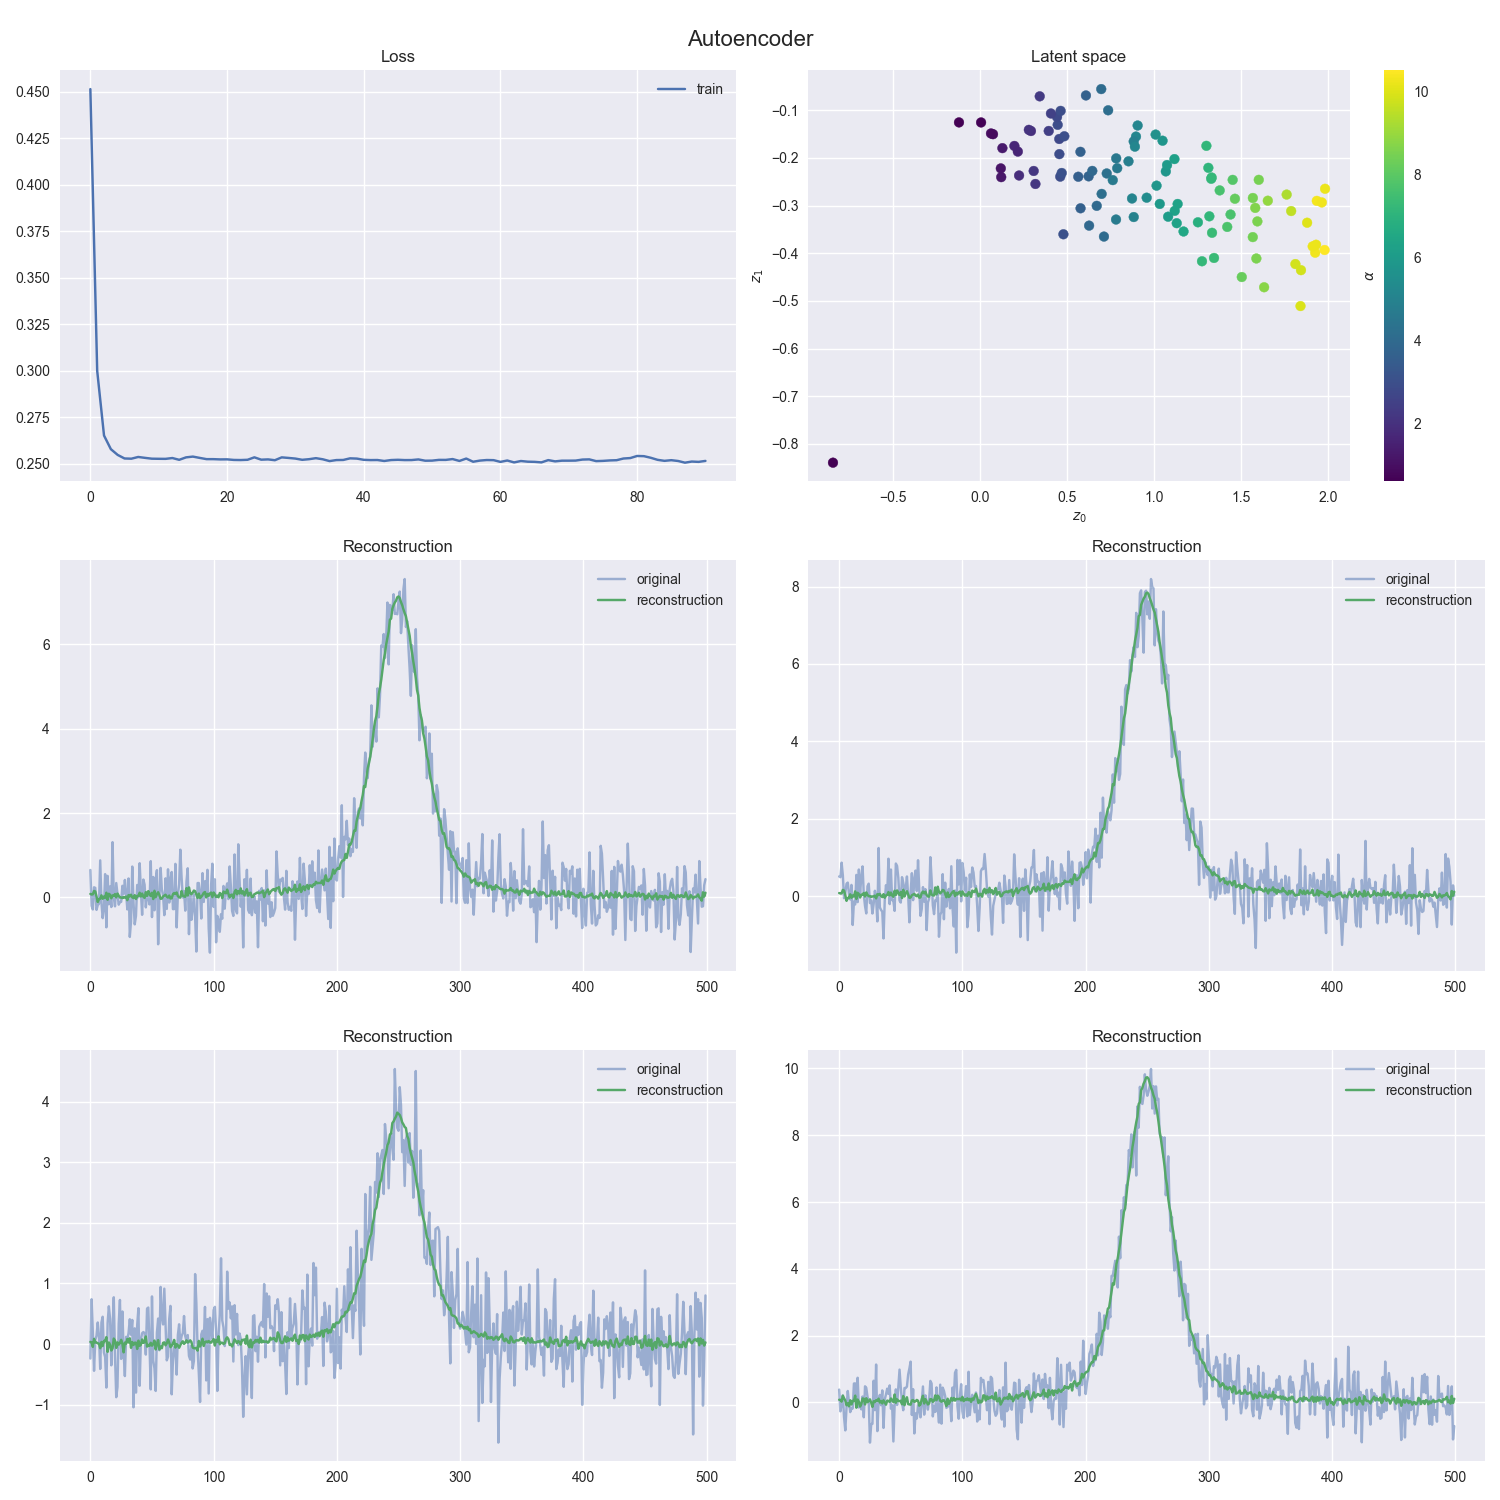

In [36]:
batch_size = 100

ps = pseudoVoigtSimulatorTorch(500)
generator = ps.generator(1, peaks = torch.tensor([250]), gamma = torch.tensor([20]), eta = torch.tensor([0.5]), alpha = (0.5,10), sigma = 0.5)

dset_train = IterDataset(generator)
dset_test = IterDataset(generator)

# Load the SERS dataset
train_loader = torch.utils.data.DataLoader(dset_train, batch_size=batch_size, pin_memory=cuda)
test_loader = torch.utils.data.DataLoader(dset_test, batch_size=batch_size, pin_memory=cuda)

epochs = 100
num_batches_per_epoch = 10
learning_rate = 0.01
optimizer = 'adam'

autoencoder, train_loss, test_loss = train(autoencoder, train_loader, test_loader, 
                                        optimizer=optimizer, epochs=epochs, 
                                        num_iterations_per_epoch=num_batches_per_epoch,
                                        lr=learning_rate, label="alpha")


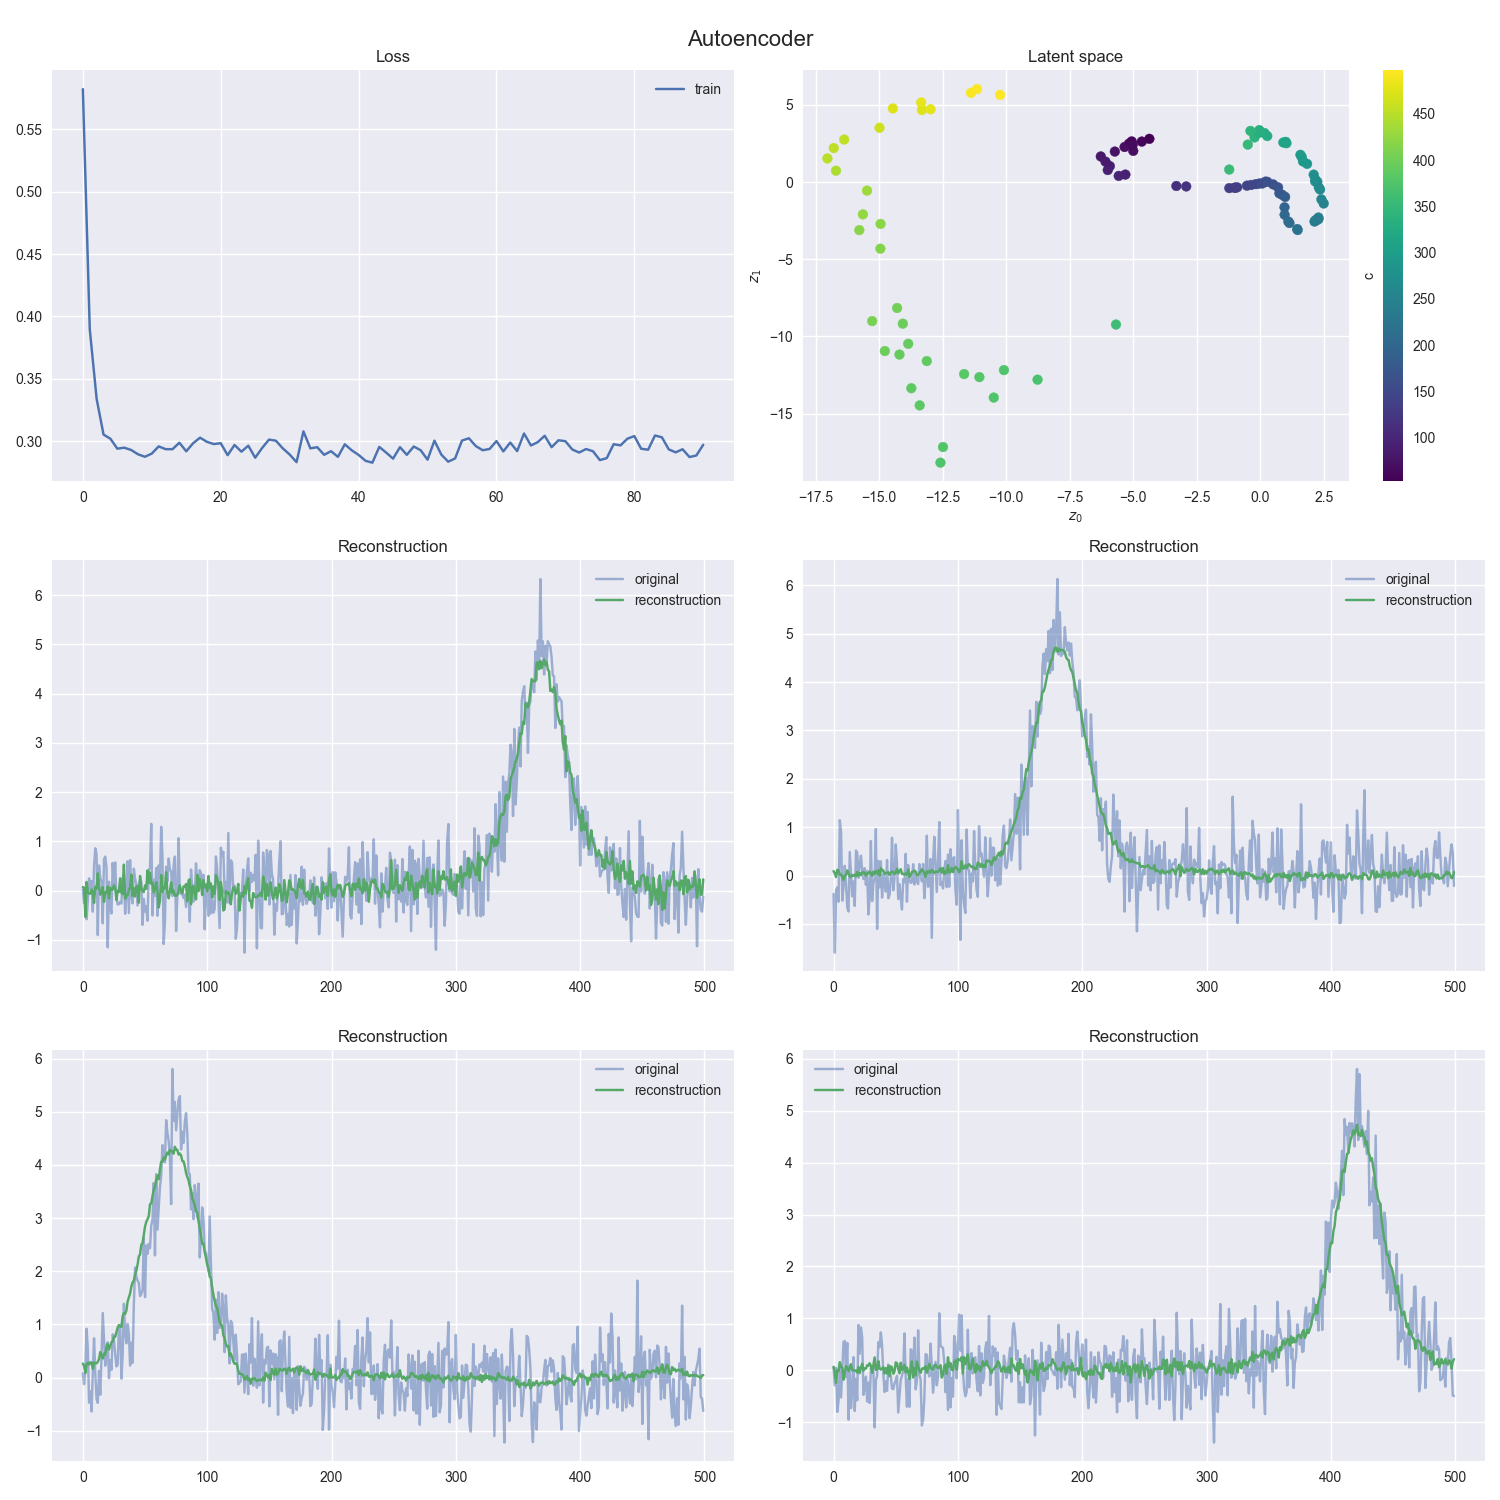

In [38]:
batch_size = 100

ps = pseudoVoigtSimulatorTorch(500)
generator = ps.generator(1, peaks = (50,450), gamma = torch.tensor([20]), eta = torch.tensor([0.5]), alpha = torch.tensor([5]), sigma = 0.5)

dset_train = IterDataset(generator)
dset_test = IterDataset(generator)

# Load the SERS dataset
train_loader = torch.utils.data.DataLoader(dset_train, batch_size=batch_size, pin_memory=cuda)
test_loader = torch.utils.data.DataLoader(dset_test, batch_size=batch_size, pin_memory=cuda)

epochs = 100
num_batches_per_epoch = 10
learning_rate = 0.01
optimizer = 'adam'

autoencoder, train_loss, test_loss = train(autoencoder, train_loader, test_loader, 
                                        optimizer=optimizer, epochs=epochs, 
                                        num_iterations_per_epoch=num_batches_per_epoch,
                                        lr=learning_rate, label="c")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


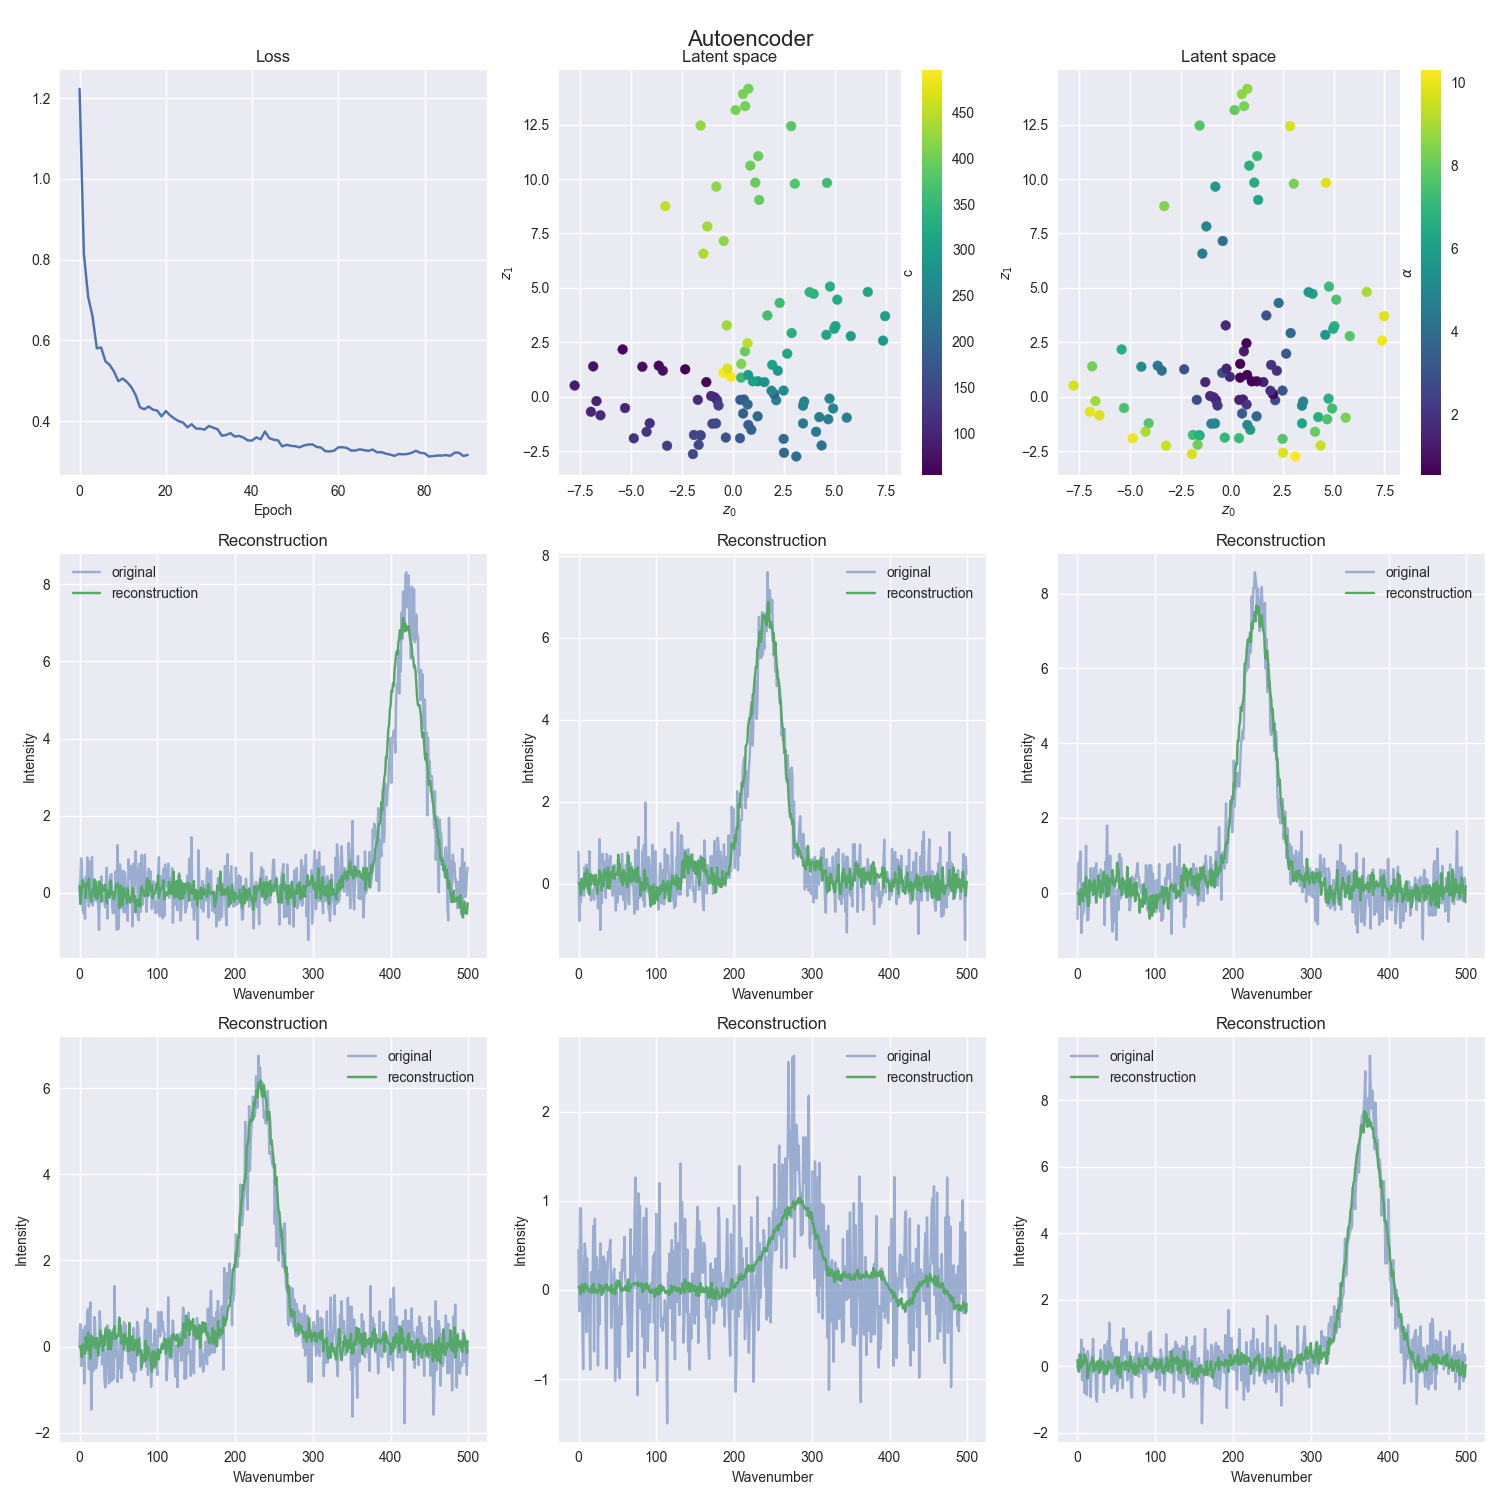

In [52]:
batch_size = 100

ps = pseudoVoigtSimulatorTorch(500)
generator = ps.generator(1, peaks = (50,450), gamma = torch.tensor([20]), eta = torch.tensor([0.5]), alpha = (0.5,10), sigma = 0.5)

dset_train = IterDataset(generator)
dset_test = IterDataset(generator)

# Load the SERS dataset
train_loader = torch.utils.data.DataLoader(dset_train, batch_size=batch_size, pin_memory=cuda)
test_loader = torch.utils.data.DataLoader(dset_test, batch_size=batch_size, pin_memory=cuda)

epochs = 100
num_batches_per_epoch = 10
learning_rate = 0.01
optimizer = 'adam'

autoencoder, train_loss, test_loss = train(autoencoder, train_loader, test_loader, 
                                        optimizer=optimizer, epochs=epochs, 
                                        num_iterations_per_epoch=num_batches_per_epoch,
                                        lr=learning_rate, label=["c", "alpha"])
